# Importing Required Libraries

In [5]:
!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# For SARIMA Model
import statsmodels.api as sm
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape

# Importing datasets

In [4]:
Ingredients_dataset = pd.read_excel("/content/Pizza_ingredients.xlsx")
Sales_dataset = pd.read_excel("/content/Pizza_Sale.xlsx")

# Sales data & Ingredients_data exploration

In [6]:
Sales_dataset.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01 00:00:00,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01 00:00:00,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [7]:
Sales_dataset.shape

(48620, 12)

In [8]:
Sales_dataset.info()
Sales_dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


,pizza_id,order_id,quantity,unit_price,total_price
count,48620.000000,48620.000000,48620.000000,48620.000000,48613.000000
mean,24310.500000,10701.479761,1.019622,16.494132,16.821494
std,14035.529381,6180.119770,0.143077,3.621789,4.437520
min,1.000000,1.000000,1.000000,9.750000,9.750000
25%,12155.750000,5337.000000,1.000000,12.750000,12.750000
50%,24310.500000,10682.500000,1.000000,16.500000,16.500000
75%,36465.250000,16100.000000,1.000000,20.250000,20.500000
max,48620.000000,21350.000000,4.000000,35.950000,83.000000


In [9]:
Ingredients_dataset.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


In [10]:
Ingredients_dataset.shape

(518, 4)

In [11]:
Ingredients_dataset.info()
Ingredients_dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pizza_name_id       518 non-null    object 
 1   pizza_name          518 non-null    object 
 2   pizza_ingredients   518 non-null    object 
 3   Items_Qty_In_Grams  514 non-null    float64
dtypes: float64(1), object(3)
memory usage: 16.3+ KB


,Items_Qty_In_Grams
count,514.000000
mean,30.564202
std,30.351623
min,5.000000
25%,10.000000
50%,20.000000
75%,40.000000
max,200.000000


In [12]:
Sales_dataset.isna().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,16
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,7
pizza_size,0
pizza_category,23


In [13]:
Sales_dataset['total_price'].fillna(Sales_dataset['unit_price'] * Sales_dataset['quantity'], inplace=True)

<ipython-input-13-6966bd0826f1>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Sales_dataset['total_price'].fillna(Sales_dataset['unit_price'] * Sales_dataset['quantity'], inplace=True)


In [14]:
Sales_dataset.isna().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,16
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,0
pizza_size,0
pizza_category,23


In [15]:
Sales_dataset['pizza_category'].value_counts()

,count
pizza_category,
Classic,14572
Supreme,11771
Veggie,11442
Chicken,10812


In [16]:
Sales_dataset[Sales_dataset['pizza_category'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
426,427,181,mexicana_l,1,2015-03-01 00:00:00,18:49:32,20.25,20.25,L,NaN,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
427,428,182,brie_carre_s,1,2015-03-01 00:00:00,18:50:10,23.65,23.65,S,NaN,"Brie Carre Cheese, Prosciutto, Caramelized Oni...",The Brie Carre Pizza
428,429,182,peppr_salami_l,1,2015-03-01 00:00:00,18:50:10,20.75,20.75,L,NaN,"Genoa Salami, Capocollo, Pepperoni, Tomatoes, ...",The Pepper Salami Pizza
429,430,183,napolitana_m,1,2015-03-01 00:00:00,18:54:55,16.00,16.00,M,NaN,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza
430,431,183,spin_pesto_l,1,2015-03-01 00:00:00,18:54:55,20.75,20.75,L,NaN,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",The Spinach Pesto Pizza


In [17]:
Sales_dataset['pizza_name_id'].value_counts()

,count
pizza_name_id,
big_meat_s,1811
thai_ckn_l,1363
five_cheese_l,1358
four_cheese_l,1272
classic_dlx_m,1159
...,...
mexicana_s,160
calabrese_s,99
ckn_alfredo_s,96


In [18]:
category_mapping = Sales_dataset[['pizza_name_id', 'pizza_category']].dropna().drop_duplicates()
category_mapping = category_mapping.set_index('pizza_name_id')['pizza_category'].to_dict()

Sales_dataset['pizza_category'] = Sales_dataset['pizza_category'].fillna(Sales_dataset['pizza_name_id'].map(category_mapping))

In [19]:
Sales_dataset.isna().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,16
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,0
pizza_size,0
pizza_category,0


In [20]:
Sales_dataset[Sales_dataset['pizza_ingredients'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
580,581,254,five_cheese_l,1,2015-04-01 00:00:00,22:22:13,18.5,18.5,L,Veggie,NaN,The Five Cheese Pizza
581,582,255,five_cheese_l,1,2015-05-01 00:00:00,11:23:35,18.5,18.5,L,Veggie,NaN,The Five Cheese Pizza
582,583,255,green_garden_m,1,2015-05-01 00:00:00,11:23:35,16.0,16.0,M,Veggie,NaN,The Green Garden Pizza
583,584,255,hawaiian_l,1,2015-05-01 00:00:00,11:23:35,16.5,16.5,L,Classic,NaN,The Hawaiian Pizza
584,585,255,spinach_fet_m,1,2015-05-01 00:00:00,11:23:35,16.0,16.0,M,Veggie,NaN,The Spinach and Feta Pizza


In [21]:
ingredients_mapping = Sales_dataset[['pizza_name', 'pizza_ingredients']].dropna().drop_duplicates()
ingredients_mapping = ingredients_mapping.set_index('pizza_name')['pizza_ingredients'].to_dict()

Sales_dataset['pizza_ingredients'] = Sales_dataset['pizza_ingredients'].fillna(Sales_dataset['pizza_name'].map(ingredients_mapping))

In [22]:
Sales_dataset[Sales_dataset['pizza_name'].isna()]

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
688,689,303,pepperoni_s,1,2015-05-01 00:00:00,20:02:51,9.75,9.75,S,Classic,"Mozzarella Cheese, Pepperoni",NaN
689,690,304,hawaiian_s,1,2015-05-01 00:00:00,20:07:58,10.50,10.50,S,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",NaN
690,691,304,mexicana_l,1,2015-05-01 00:00:00,20:07:58,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",NaN
691,692,305,pepperoni_l,1,2015-05-01 00:00:00,20:35:40,15.25,15.25,L,Classic,"Mozzarella Cheese, Pepperoni",NaN
692,693,305,sicilian_s,1,2015-05-01 00:00:00,20:35:40,12.25,12.25,S,Supreme,"Coarse Sicilian Salami, Tomatoes, Green Olives...",NaN
693,694,305,spicy_ital_m,1,2015-05-01 00:00:00,20:35:40,16.50,16.50,M,Supreme,"Capocollo, Tomatoes, Goat Cheese, Artichokes, ...",NaN
694,695,306,big_meat_s,1,2015-05-01 00:00:00,20:37:40,12.00,12.00,S,Classic,"Bacon, Pepperoni, Italian Sausage, Chorizo Sau...",NaN


In [23]:
len(Sales_dataset['pizza_ingredients'].value_counts())

32

In [24]:
ingredients_name_mapping = Sales_dataset[['pizza_ingredients', 'pizza_name']].dropna().drop_duplicates()
ingredients_name_mapping = ingredients_name_mapping.set_index('pizza_ingredients')['pizza_name'].to_dict()

Sales_dataset['pizza_name'] = Sales_dataset['pizza_name'].fillna(Sales_dataset['pizza_ingredients'].map(ingredients_name_mapping))

In [25]:
Sales_dataset.isna().sum()


,0
pizza_id,0
order_id,0
pizza_name_id,16
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,0
pizza_size,0
pizza_category,0


In [26]:
name_id_mapping = Sales_dataset[['pizza_name', 'pizza_name_id']].dropna().drop_duplicates()
name_id_mapping = name_id_mapping.set_index('pizza_name')['pizza_name_id'].to_dict()

Sales_dataset['pizza_name_id'] = Sales_dataset['pizza_name_id'].fillna(Sales_dataset['pizza_name'].map(name_id_mapping))


In [27]:
Sales_dataset.isna().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,0
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,0
pizza_size,0
pizza_category,0


In [28]:
Ingredients_dataset.isna().sum()

,0
pizza_name_id,0
pizza_name,0
pizza_ingredients,0
Items_Qty_In_Grams,4


In [29]:
Ingredients_dataset[Ingredients_dataset['Items_Qty_In_Grams'].isna()]

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
24,brie_carre_s,The Brie Carre Pizza,Caramelized Onions,NaN
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,NaN
155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,NaN


In [30]:
mean_qty = Ingredients_dataset.groupby('pizza_name_id')['Items_Qty_In_Grams'].mean()

In [31]:
Ingredients_dataset['Items_Qty_In_Grams'] = Ingredients_dataset['Items_Qty_In_Grams'].fillna(Ingredients_dataset['pizza_name_id'].map(mean_qty))

In [32]:
remaining_missing_qty = Ingredients_dataset['Items_Qty_In_Grams'].isna().sum()
print(f"Remaining missing Items_Qty_In_Grams: {remaining_missing_qty}")

Remaining missing Items_Qty_In_Grams: 0


In [33]:
Ingredients_dataset.isna().sum()

,0
pizza_name_id,0
pizza_name,0
pizza_ingredients,0
Items_Qty_In_Grams,0


In [34]:
merged_data = pd.merge(Sales_dataset, Ingredients_dataset, on='pizza_name_id', how='left')

In [35]:
merged_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients_x,pizza_name_x,pizza_name_y,pizza_ingredients_y,Items_Qty_In_Grams
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Sliced Ham,25.0
1,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Pineapple,30.0
2,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Mozzarella Cheese,20.0
3,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Pepperoni,40.0
4,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Mushrooms,40.0


In [36]:
merged_data.isnull().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,0
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,0
pizza_size,0
pizza_category,0


In [37]:
merged_data[['pizza_ingredients_x','pizza_ingredients_y']]

,pizza_ingredients_x,pizza_ingredients_y
0,"Sliced Ham, Pineapple, Mozzarella Cheese",Sliced Ham
1,"Sliced Ham, Pineapple, Mozzarella Cheese",Pineapple
2,"Sliced Ham, Pineapple, Mozzarella Cheese",Mozzarella Cheese
3,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Pepperoni
4,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Mushrooms
...,...,...
267571,"Barbecued Chicken, Red Peppers, Green Peppers,...",Red Peppers
267572,"Barbecued Chicken, Red Peppers, Green Peppers,...",Green Peppers
267573,"Barbecued Chicken, Red Peppers, Green Peppers,...",Tomatoes
267574,"Barbecued Chicken, Red Peppers, Green Peppers,...",Red Onions


In [38]:
merged_data[['pizza_name_x','pizza_name_y']]

,pizza_name_x,pizza_name_y
0,The Hawaiian Pizza,The Hawaiian Pizza
1,The Hawaiian Pizza,The Hawaiian Pizza
2,The Hawaiian Pizza,The Hawaiian Pizza
3,The Classic Deluxe Pizza,The Classic Deluxe Pizza
4,The Classic Deluxe Pizza,The Classic Deluxe Pizza
...,...,...
267571,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267572,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267573,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267574,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza


In [39]:
merged_data.drop(columns=['pizza_name_y', 'pizza_ingredients_y'], inplace=True)
merged_data.rename(columns={
    'pizza_name_x': 'pizza_name',
    'pizza_ingredients_x': 'pizza_ingredients'
}, inplace=True)

In [40]:
merged_data.columns

Index(['pizza_id', 'order_id', 'pizza_name_id', 'quantity', 'order_date',
       'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name',
       'Items_Qty_In_Grams'],
      dtype='object')

In [41]:
merged_data.duplicated().sum()


80204

In [42]:
# Droping duplicate rows from the dataset
merged_data = merged_data.drop_duplicates()

print(f"Number of rows after removing duplicates: {merged_data.shape[0]}")

Number of rows after removing duplicates: 187372


In [43]:
merged_data1 = merged_data.copy()

In [44]:
# Summary statistics
merged_data.describe()


,pizza_id,order_id,quantity,unit_price,total_price,Items_Qty_In_Grams
count,187372.000000,187372.000000,187372.000000,187372.000000,187372.000000,187372.000000
mean,24312.676030,10702.312405,1.019250,16.914338,17.244843,37.645900
std,14039.560378,6181.841091,0.141575,3.571451,4.419979,35.729459
min,1.000000,1.000000,1.000000,9.750000,9.750000,5.000000
25%,12166.750000,5344.000000,1.000000,12.750000,12.750000,15.000000
50%,24266.000000,10661.000000,1.000000,16.750000,16.750000,20.000000
75%,36494.250000,16112.250000,1.000000,20.500000,20.750000,45.000000
max,48620.000000,21350.000000,4.000000,35.950000,83.000000,200.000000


In [45]:
# Checking the data types and column names
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187372 entries, 0 to 267573
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pizza_id            187372 non-null  int64  
 1   order_id            187372 non-null  int64  
 2   pizza_name_id       187372 non-null  object 
 3   quantity            187372 non-null  int64  
 4   order_date          187372 non-null  object 
 5   order_time          187372 non-null  object 
 6   unit_price          187372 non-null  float64
 7   total_price         187372 non-null  float64
 8   pizza_size          187372 non-null  object 
 9   pizza_category      187372 non-null  object 
 10  pizza_ingredients   187372 non-null  object 
 11  pizza_name          187372 non-null  object 
 12  Items_Qty_In_Grams  187372 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 20.0+ MB


In [46]:
def extract_date(date):
    formats = ['%d-%m-%Y', '%d/%m/%Y', '%m/%d/%Y']
    for fmt in formats:
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    return pd.NaT

# Applying the function to the 'order_date' column
merged_data['order_date'] = merged_data['order_date'].apply(extract_date)

In [47]:
# Extracting the day of the week
merged_data['day_of_week'] = merged_data['order_date'].dt.dayofweek # day_name()
merged_data['day_of_week']
# Extracting the month
merged_data['month'] = merged_data['order_date'].dt.month # month_name()
# Createing a new column for the week number
merged_data['week'] = merged_data['order_date'].dt.isocalendar().week
# Extracting the year
merged_data['year'] = merged_data['order_date'].dt.year

In [48]:
pip install holidays

In [49]:
import holidays

# using US holidays
us_holidays = holidays.US()

# Creating a 'holiday' column that indicates if the order_date was a holiday
merged_data['holiday'] = merged_data['order_date'].apply(lambda x: 1 if x in us_holidays else 0)

# Checking if the holiday flag works
merged_data[['order_date', 'holiday']].head()

,order_date,holiday
0,2015-01-01,1
1,2015-01-01,1
2,2015-01-01,1
3,2015-01-01,1
6,2015-01-01,1


In [50]:
merged_data[['order_date', 'holiday']].tail()

,order_date,holiday
267565,2015-12-31,0
267567,2015-12-31,0
267570,2015-12-31,0
267571,2015-12-31,0
267573,2015-12-31,0


In [51]:
# Creating a 'promotional_period' flag for weekends
merged_data['promotion'] = merged_data['order_date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

# Checking if the promotion flag works
merged_data[['order_date', 'promotion']].head()

,order_date,promotion
0,2015-01-01,0
1,2015-01-01,0
2,2015-01-01,0
3,2015-01-01,0
6,2015-01-01,0


In [52]:
merged_data[merged_data['promotion'] == 1][['order_date', 'promotion']].head()

,order_date,promotion
910,2015-02-01,1
911,2015-02-01,1
914,2015-02-01,1
917,2015-02-01,1
918,2015-02-01,1


In [53]:
merged_data.isnull().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,0
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,0
pizza_size,0
pizza_category,0


In [54]:
merged_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,day_of_week,month,week,year,holiday,promotion
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,25.0,3,1,1,2015,1,0
1,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,30.0,3,1,1,2015,1,0
2,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,20.0,3,1,1,2015,1,0
3,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0,3,1,1,2015,1,0
6,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,10.0,3,1,1,2015,1,0


In [55]:
# Aggregateing sales data by date
daily_sales = merged_data.groupby('order_date')['quantity'].sum().reset_index()
daily_sales


,order_date,quantity
0,2015-01-01,620
1,2015-01-02,741
2,2015-01-03,379
3,2015-01-04,508
4,2015-01-05,594
...,...,...
353,2015-12-27,347
354,2015-12-28,381
355,2015-12-29,302
356,2015-12-30,327


# Exploratory Data Analysis (EDA)

# Sales Trends Over Time

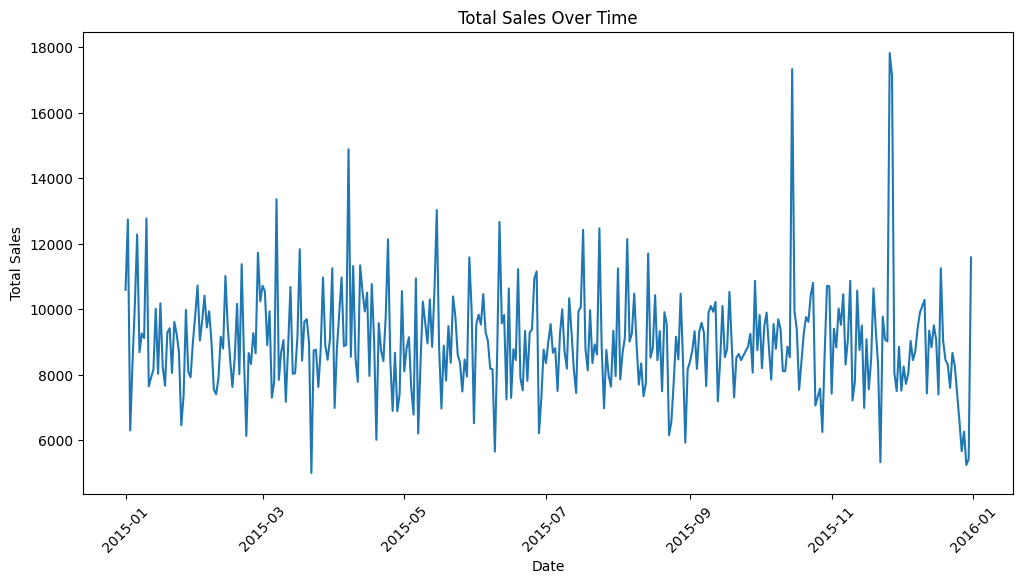

In [56]:
# Ploting sales over time
sales_over_time = merged_data.groupby('order_date')['total_price'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=sales_over_time, x='order_date', y='total_price')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

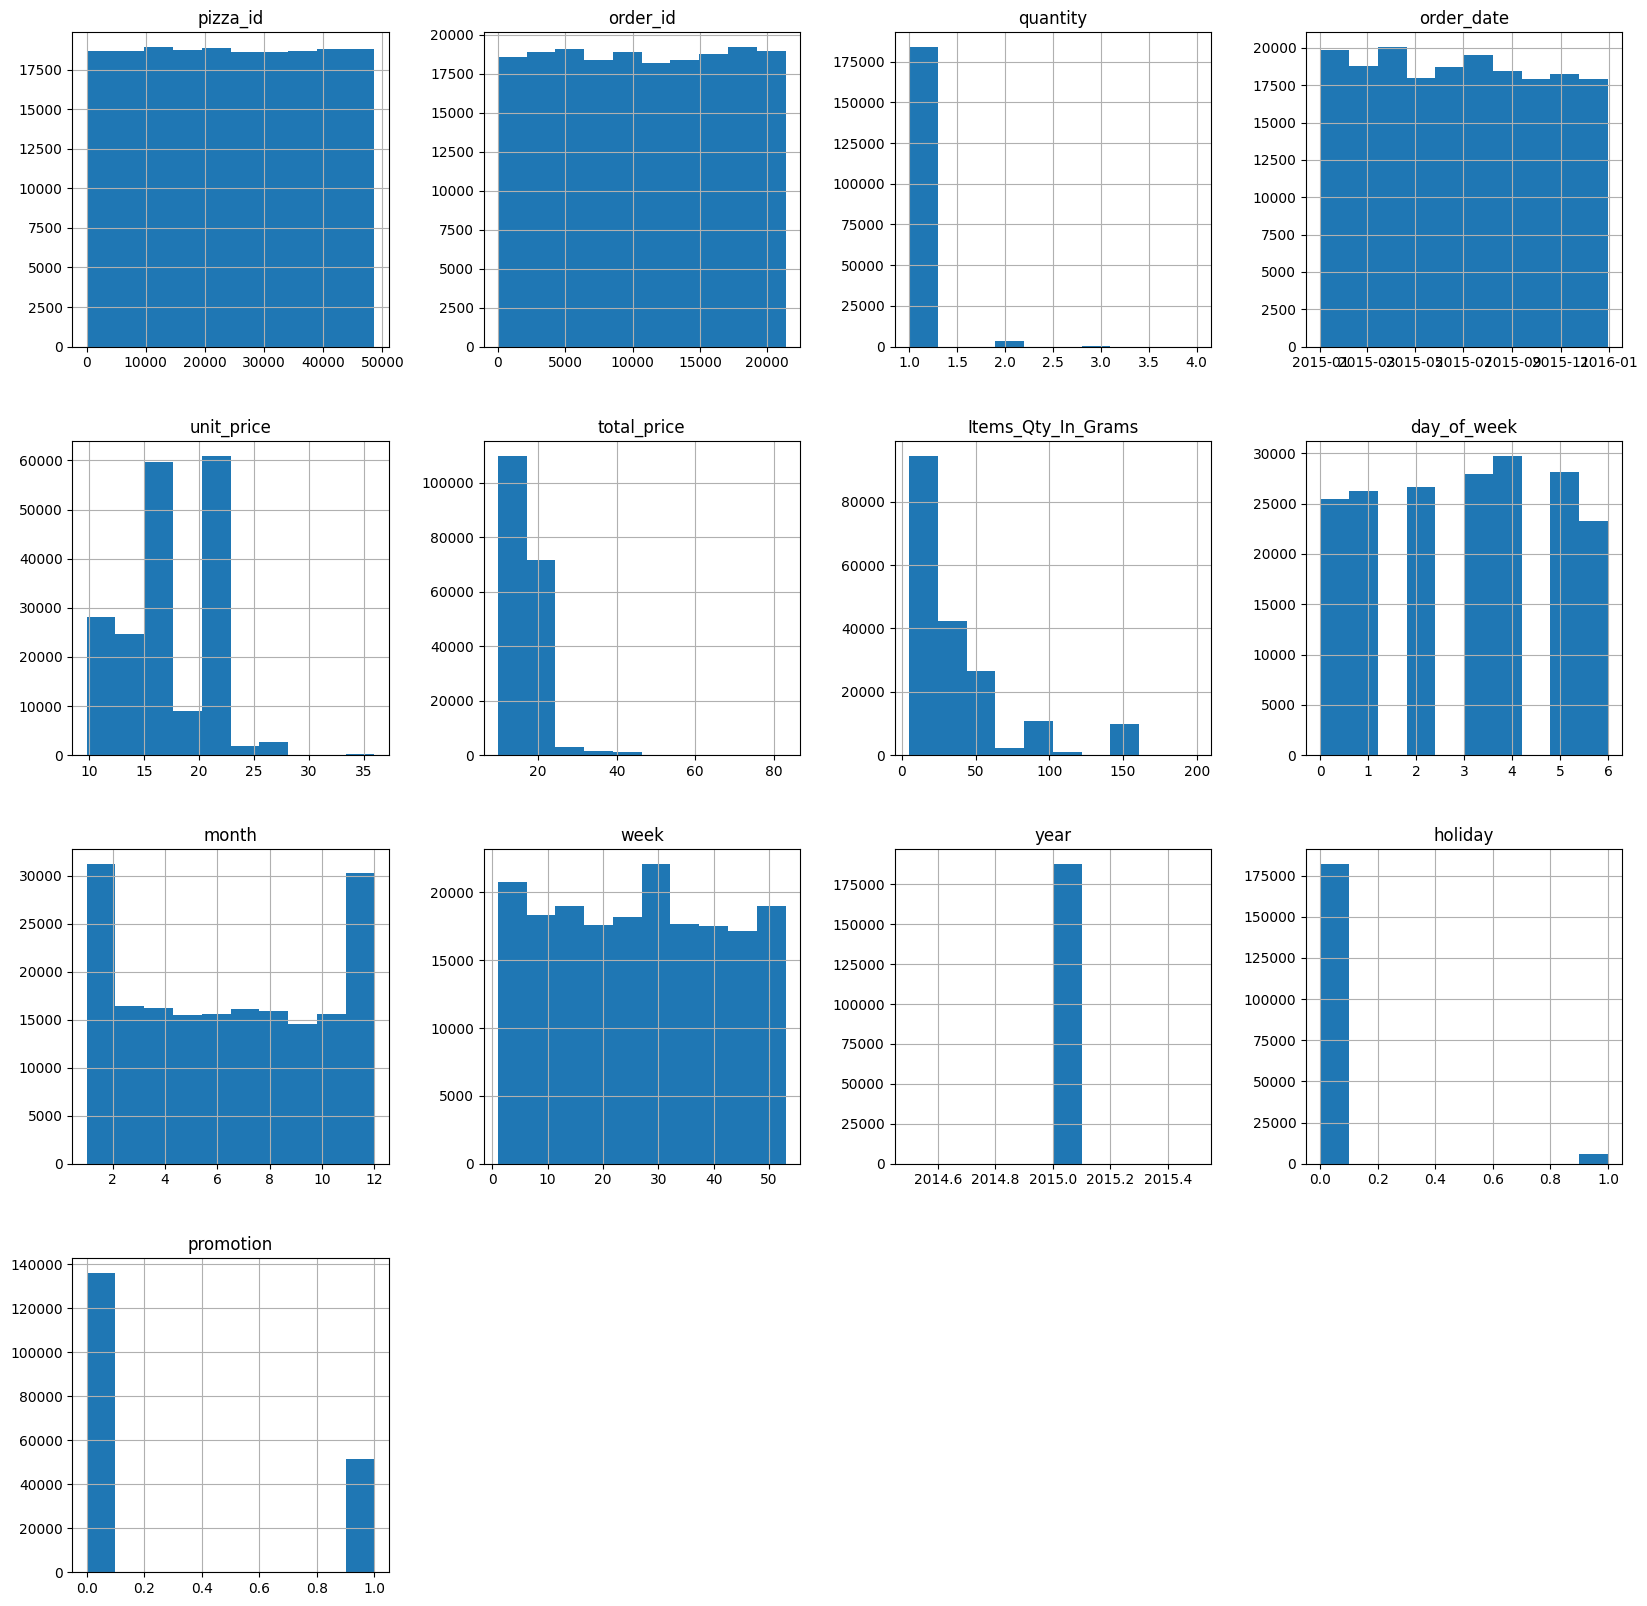

In [57]:
merged_data.hist(figsize=(20,20))
plt.show()

<ipython-input-58-003a87b6dd9d>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pizza_sales.head(10), x='quantity', y='pizza_name', palette='viridis')


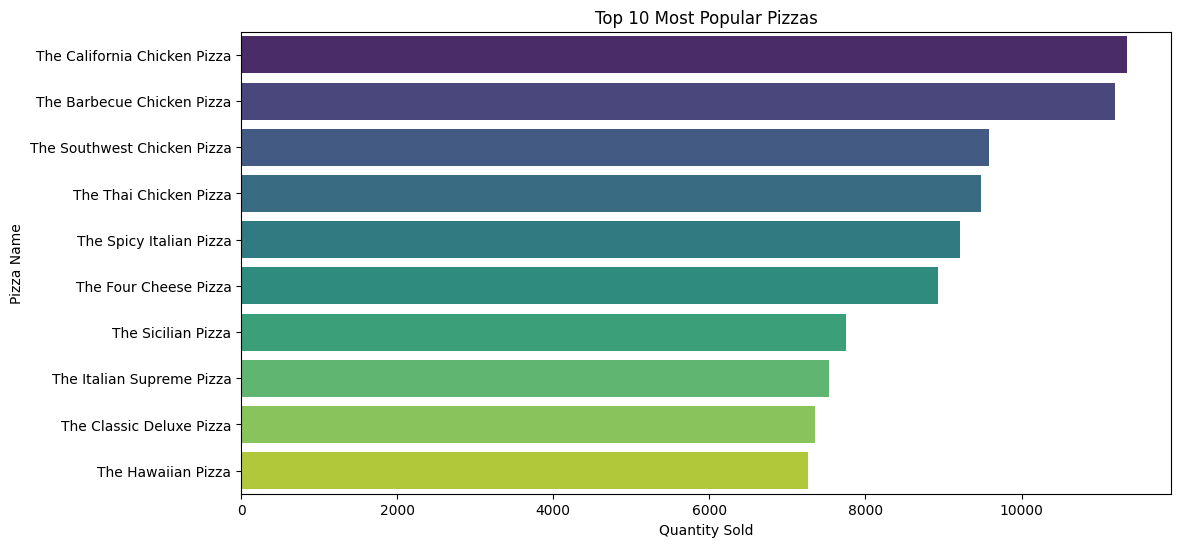

In [58]:
# Aggregate sales by pizza name
pizza_sales = merged_data.groupby('pizza_name')['quantity'].sum().reset_index()

# Sorting by quantity sold
pizza_sales = pizza_sales.sort_values(by='quantity', ascending=False)

# Ploting top 10 most popular pizzas
plt.figure(figsize=(12,6))
sns.barplot(data=pizza_sales.head(10), x='quantity', y='pizza_name', palette='viridis')
plt.title('Top 10 Most Popular Pizzas')
plt.xlabel('Quantity Sold')
plt.ylabel('Pizza Name')
plt.show()

# Sales by Pizza Size

<ipython-input-59-93c78163eb73>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=size_sales, x='pizza_size', y='quantity', palette='coolwarm')


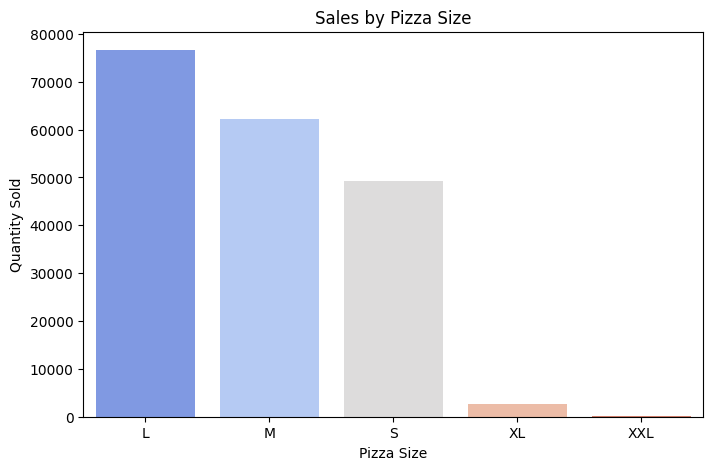

In [59]:
# Ploting pizza size distribution
size_sales = merged_data.groupby('pizza_size')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=size_sales, x='pizza_size', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Size')
plt.xlabel('Pizza Size')
plt.ylabel('Quantity Sold')
plt.show()

# Sales by Pizza Category

<ipython-input-60-7e6dc0dafef5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_sales, x='pizza_category', y='quantity', palette='coolwarm')


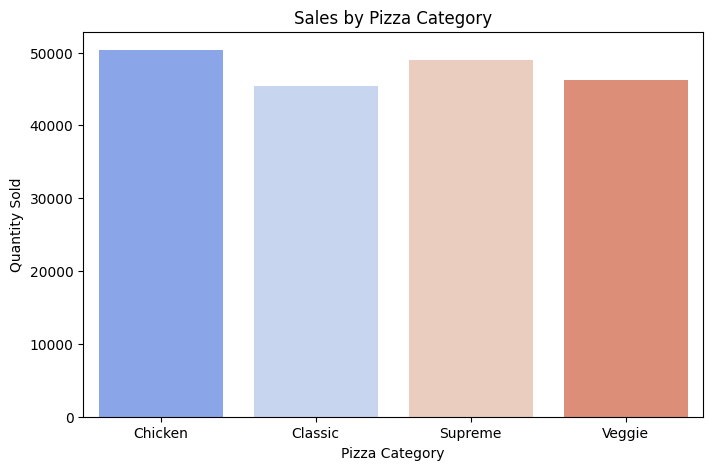

In [60]:
# Ploting pizza category distribution
category_sales = merged_data.groupby('pizza_category')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=category_sales, x='pizza_category', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Category')
plt.xlabel('Pizza Category')
plt.ylabel('Quantity Sold')
plt.show()

# Sales by Day of the Week


<ipython-input-61-c404cd67989e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_by_day, x='day_of_week', y='total_price', palette='viridis')


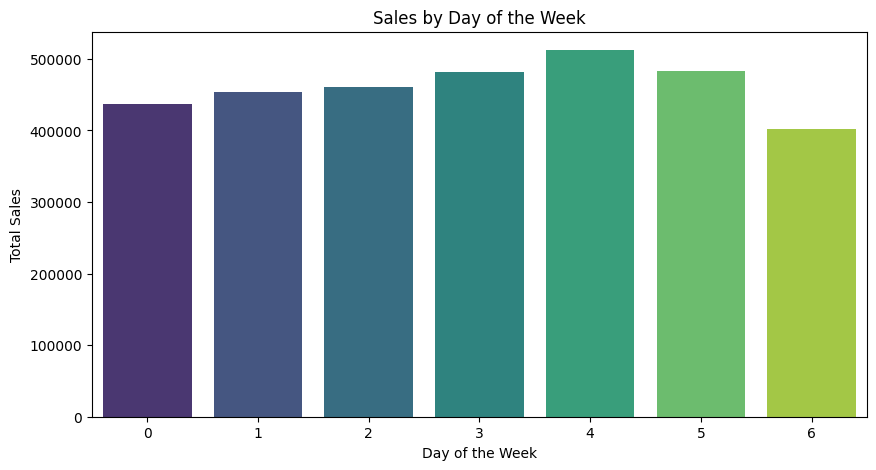

In [61]:
# Aggregate sales by day of the week
sales_by_day = merged_data.groupby('day_of_week')['total_price'].sum().reset_index()

# Order days of the week
#days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_order = [0, 1, 2, 3, 4, 5, 6]
sales_by_day['day_of_week'] = pd.Categorical(sales_by_day['day_of_week'], categories=days_order, ordered=True)

# Plot sales by day of the week
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_day, x='day_of_week', y='total_price', palette='viridis')
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.show()

# Sales by Month

<ipython-input-62-6298cb767f0f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_by_month, x='month', y='total_price', palette='magma')


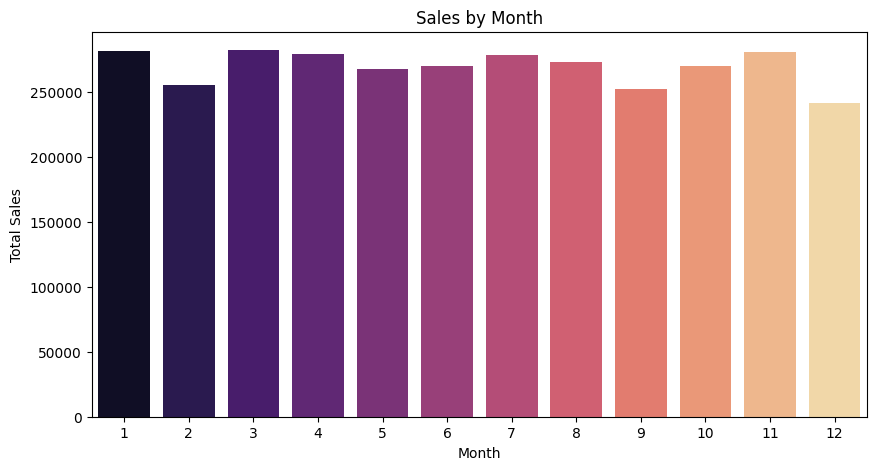

In [62]:
# Aggregate sales by month
sales_by_month = merged_data.groupby('month')['total_price'].sum().reset_index()

# Plot sales by month
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_month, x='month', y='total_price', palette='magma')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()


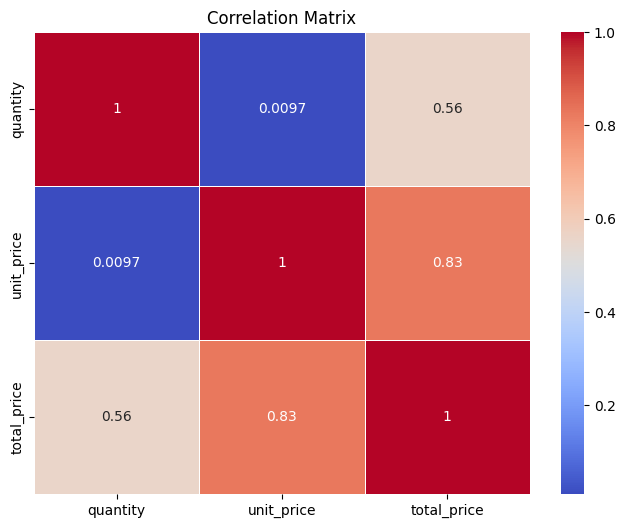

In [63]:
# Correlation matrix
corr_matrix = merged_data[['quantity', 'unit_price', 'total_price']].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

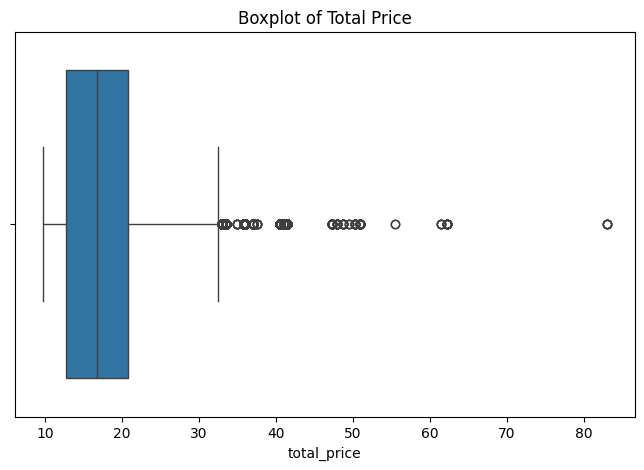

In [64]:
# Boxplot for total_price
plt.figure(figsize=(8,5))
sns.boxplot(data=merged_data, x='total_price')
plt.title('Boxplot of Total Price')
plt.show()

# Sales on Holidays vs Non-Holidays

<ipython-input-65-8044d1ba6d31>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='holiday', y='total_price', data=merged_data, palette='viridis')


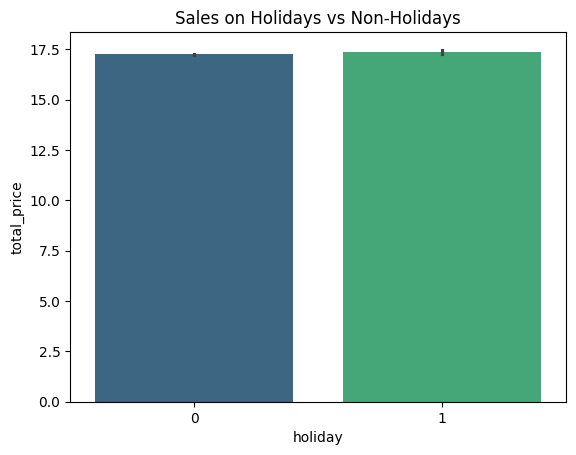

In [65]:
sns.barplot(x='holiday', y='total_price', data=merged_data, palette='viridis')
plt.title('Sales on Holidays vs Non-Holidays')
plt.show()

# Sales during promotions vs non-promotions

<ipython-input-66-39853dcc0419>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='promotion', y='total_price', data=merged_data, palette='magma')


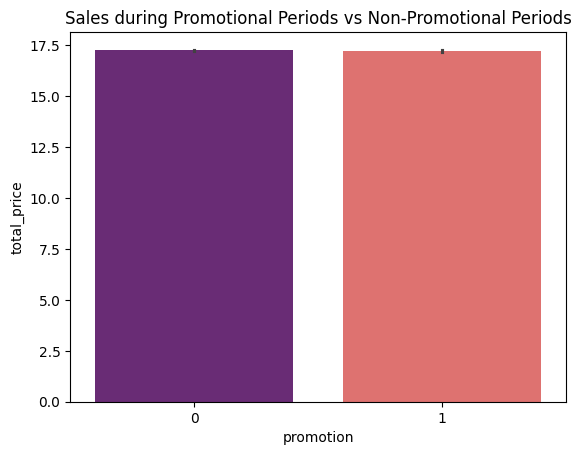

In [66]:
sns.barplot(x='promotion', y='total_price', data=merged_data, palette='magma')
plt.title('Sales during Promotional Periods vs Non-Promotional Periods')
plt.show()

In [67]:
# Merged Sales and Ingredients DataFrames and Preprocessed the data to create a comprehensive pizza sales dataset
pizza_sales = merged_data

In [68]:
# Prepare weekly pizza sales data.
# Split data into training (80%) and testing (20%) sets.
# Tune the ARIMA model by testing different parameter combinations.
# Identify the best ARIMA model using MAPE.
# Visualize how well the model predicts sales compared to actual data.

# ARIMA

In [69]:
# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# ARIMA Model Tuneing
def tune_arima_model(train, test, p_values, d_values, q_values):
    best_score, best_params, best_predictions = float("inf"), None, None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q)).fit()
            predictions = model.forecast(steps=len(test))
            arima_mape = mape(test, predictions)
            if arima_mape < best_score:
                best_score, best_params, best_predictions = arima_mape, (p, d, q), predictions
        except:
            continue

    print(f"Best ARIMA Model MAPE: {best_score:.4f}, Best Parameters: {best_params}")
    return best_predictions, best_score, best_params

p_values, d_values, q_values = range(0, 6), range(0, 2), range(0, 6)
arima_predictions, arima_mape_score, best_params = tune_arima_model(train, test, p_values, d_values, q_values)

# Formating the predictions for display
arima_predictions = pd.Series(arima_predictions, index=test.index)

print("Predictions:")
print(arima_predictions)

# # Plot actual vs predicted values
# plt.figure(figsize=(12, 6))
# plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
# plt.plot(arima_predictions.index, arima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
# plt.title('ARIMA Predictions vs Actual Sales')
# plt.xlabel('Date')
# plt.ylabel('Weekly Sales')
# plt.xticks(rotation=45)
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  

Best ARIMA Model MAPE: 0.1976, Best Parameters: (3, 1, 5)
Predictions:
order_date
2015-10-19    3453.621947
2015-10-26    3839.852295
2015-11-02    3634.093874
2015-11-09    3649.615095
2015-11-16    3552.311612
2015-11-23    3876.134061
2015-11-30    3532.251213
2015-12-07    3659.119487
2015-12-14    3649.664429
2015-12-21    3822.957176
2015-12-28    3458.981438
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# SARIMA (Seasonal ARIMA)

# Autoregressive (AR) terms p==The model predicts the current value based on past values
 Differencing terms  d==Represents the number of times the data is differenced to achieve stationarity (constant mean and variance over time).
Moving Average (MA) terms===The model corrects the current prediction based on the errors of previous predictions

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  

Best SARIMA Model MAPE: 0.1507, Best Parameters: (1, 0, 1, 2, 0, 0)


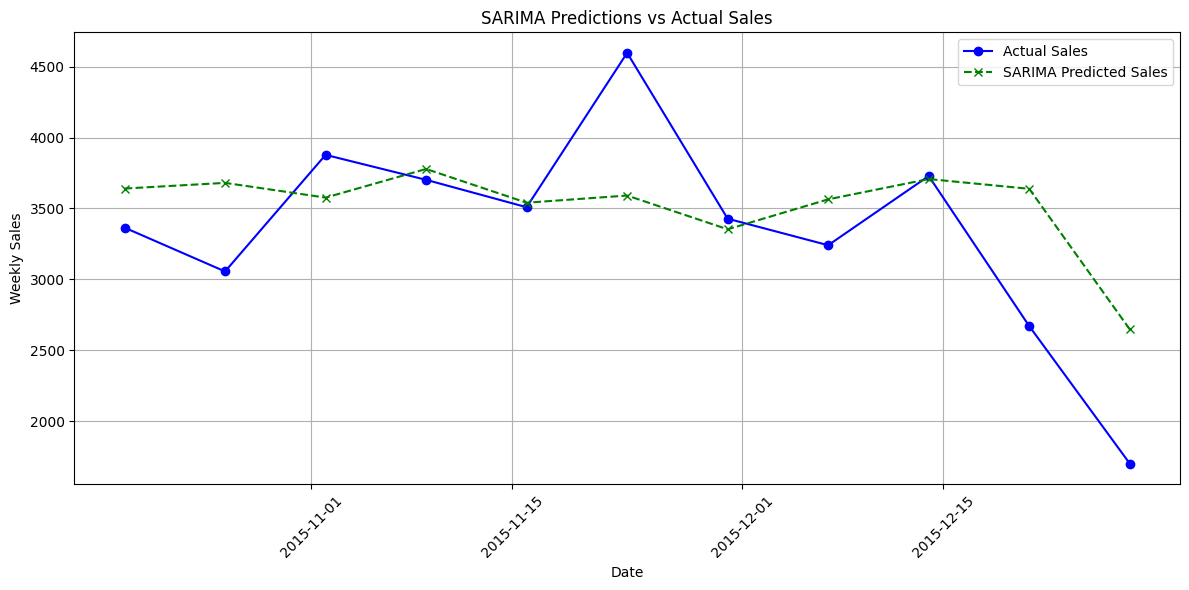

In [70]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# SARIMA Model Tuning
def tune_sarima_model(train, test, p_values, d_values, q_values, P_values, D_values, Q_values, seasonal_period):
    best_score, best_params, best_predictions = float("inf"), None, None

    # Iterate over all combinations of parameters
    for p, d, q, P, D, Q in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values):
        try:
            # Define SARIMA model
            model = SARIMAX(train,
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, seasonal_period),
                            enforce_stationarity=False,
                            enforce_invertibility=False).fit(disp=False)

            # Forecast
            predictions = model.forecast(steps=len(test))
            sarima_mape = mape(test, predictions)

            # Check if this is the best model
            if sarima_mape < best_score:
                best_score, best_params, best_predictions = sarima_mape, (p, d, q, P, D, Q), predictions
        except:
            continue

    print(f"Best SARIMA Model MAPE: {best_score:.4f}, Best Parameters: {best_params}")
    return best_predictions, best_score, best_params

# Define hyperparameter ranges
p_values, d_values, q_values = range(0, 3), range(0, 2), range(0, 3)
P_values, D_values, Q_values = range(0, 3), range(0, 2), range(0, 3)
seasonal_period = 7  # Weekly seasonality

# Tune SARIMA model
sarima_predictions, sarima_mape_score, best_sarima_params = tune_sarima_model(
    train, test, p_values, d_values, q_values, P_values, D_values, Q_values, seasonal_period
)

# Formatting predictions for display
sarima_predictions = pd.Series(sarima_predictions, index=test.index)

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(sarima_predictions.index, sarima_predictions, label='SARIMA Predicted Sales', color='green', linestyle='--', marker='x')
plt.title('SARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Prophet (Developed by Facebook)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl0s14ftv/oqyymjd9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl0s14ftv/z5opvhv8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76145', 'data', 'file=/tmp/tmpl0s14ftv/oqyymjd9.json', 'init=/tmp/tmpl0s14ftv/z5opvhv8.json', 'output', 'file=/tmp/tmpl0s14ftv/prophet_model6rsp2li9/prophet_model-20250110091644.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
09:16:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:16:44 - cmdstanpy - INFO - Chai

Best Prophet Model MAPE: 0.2163
Predictions:
ds
2015-10-19    3684.955697
2015-10-26    3685.691317
2015-11-02    3686.426937
2015-11-09    3687.162557
2015-11-16    3687.898177
2015-11-23    3688.633796
2015-11-30    3689.369416
2015-12-07    3690.105036
2015-12-14    3690.840656
2015-12-21    3691.576276
2015-12-28    3692.311896
dtype: float64


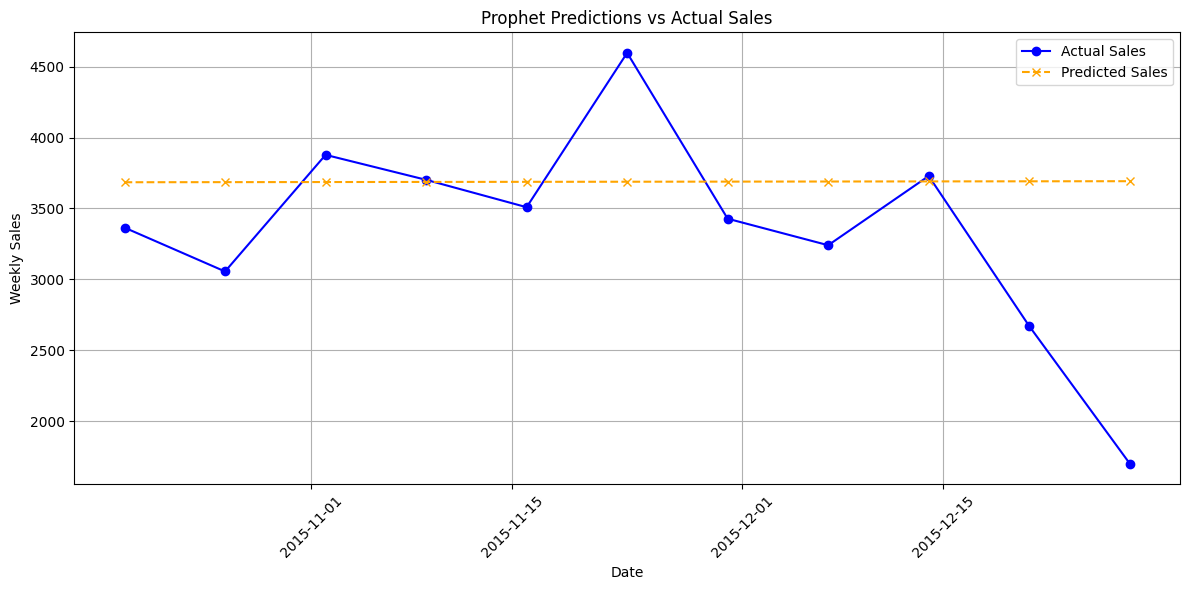

In [71]:
# Pizza sales by week
def prepare_weekly_sales_for_prophet(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    weekly_sales.columns = ['ds', 'y']  # Prophet requires columns 'ds' for date and 'y' for the target variable
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales_for_prophet(pizza_sales)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Best Prophet Model Training and Output
def best_prophet_model(train, test):
    model = Prophet()
    model.fit(train)

    future = model.make_future_dataframe(periods=len(test), freq='W')
    forecast = model.predict(future)
    predictions = forecast['yhat'][-len(test):].values
    prophet_mape = mape(test['y'].values, predictions)

    print(f"Best Prophet Model MAPE: {prophet_mape:.4f}")
    return predictions, prophet_mape

# Train and evaluate the Prophet model
prophet_predictions, prophet_mape_score = best_prophet_model(train, test)

# Formating the predictions for display
prophet_predictions = pd.Series(prophet_predictions, index=test['ds'])

print("Predictions:")
print(prophet_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Actual Sales', color='blue', marker='o')
plt.plot(prophet_predictions.index, prophet_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Prophet Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# LSTM

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Best LSTM Model MAPE: 0.2470
Predictions:
order_date
2015-11-09    3549.430908
2015-11-16    3612.221680
2015-11-23    3764.247803
2015-11-30    3875.210938
2015-12-07    3855.649658
2015-12-14    3869.612305
2015-12-21    3577.636475
2015-12-28    3449.899170
dtype: float32


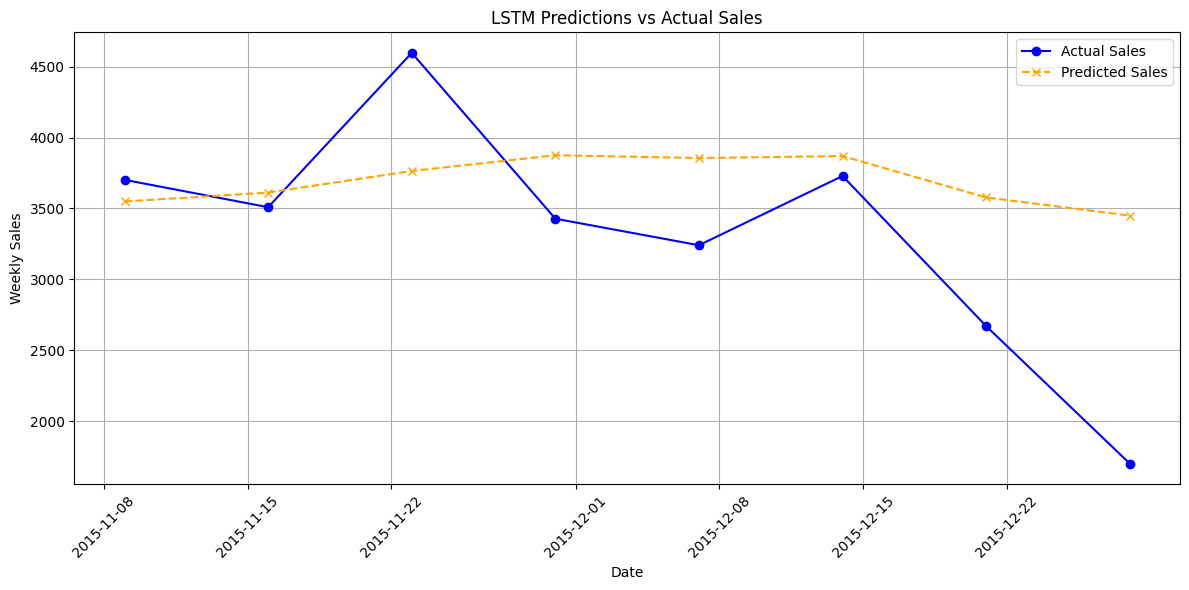

In [72]:
# Pizza sales by week
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Normalizeing the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['quantity']])
test_scaled = scaler.transform(test[['quantity']])

# Prepareing data for LSTM
def create_lstm_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 3
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# Reshapeing X for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Training LSTM Model
def best_lstm_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    lstm_mape = mape(y_test_rescaled, predictions)

    print(f"Best LSTM Model MAPE: {lstm_mape:.4f}")
    return predictions, lstm_mape, y_test_rescaled

# Train and evaluate the LSTM model
lstm_predictions, lstm_mape_score, y_test_rescaled = best_lstm_model(X_train, y_train, X_test, y_test)

# Formating the predictions for display
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test['order_date'][time_steps:])

print("Predictions:")
print(lstm_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'][time_steps:], y_test_rescaled, label='Actual Sales', color='blue', marker='o')
plt.plot(lstm_predictions.index, lstm_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('LSTM Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Model Comparision

In [73]:
import pandas as pd
# Model results as a dictionary
model_performance = {
    'Model': ['SARIMA', 'ARIMA', 'Prophet', 'LSTM'],
    'MAPE': [0.1336, 0.1968, 0.2163, 0.2243]
}

# Createing a DataFrame
df_performance = pd.DataFrame(model_performance)

# Highlight best and worst models
df_performance['Rank'] = df_performance['MAPE'].rank()
df_performance = df_performance.sort_values('MAPE', ascending=True)
df_performance['Best/Worst'] = df_performance['MAPE'].apply(lambda x: 'Best' if x == df_performance['MAPE'].min() else 'Worst' if x == df_performance['MAPE'].max() else '')

# Display table
df_performance

,Model,MAPE,Rank,Best/Worst
0,SARIMA,0.1336,1.0,Best
1,ARIMA,0.1968,2.0,
2,Prophet,0.2163,3.0,
3,LSTM,0.2243,4.0,Worst


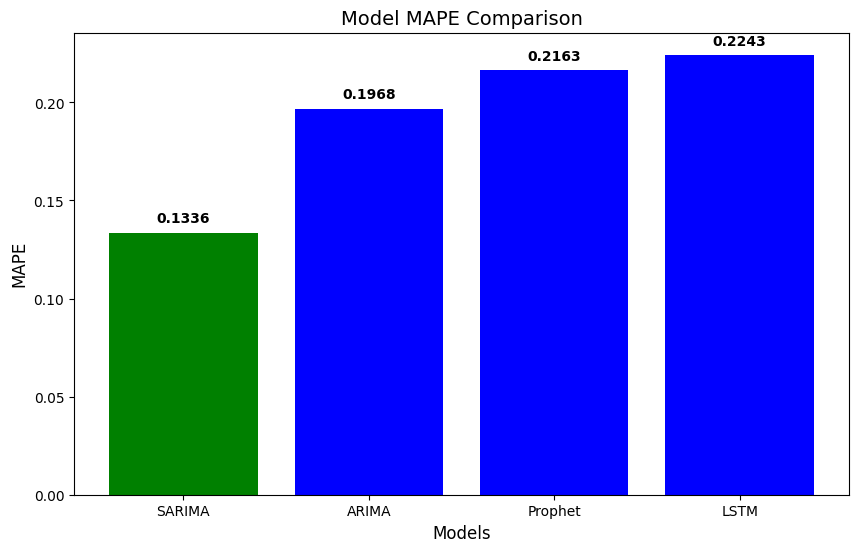

In [74]:
import matplotlib.pyplot as plt

# Data for plotting
models = ['SARIMA', 'ARIMA', 'Prophet', 'LSTM']
mapes = [0.1336, 0.1968, 0.2163, 0.2243]

plt.figure(figsize=(10,6))
plt.bar(models, mapes, color=['green', 'blue', 'blue', 'blue', 'red'])

# Highlighting the best and worst models
plt.title('Model MAPE Comparison', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('MAPE', fontsize=12)

for i, v in enumerate(mapes):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

plt.show()

# Sarima Evaluation

In [75]:
# Prepare weekly sales data for each pizza type
def prepare_weekly_pizza_sales(data):
    data['order_date'] = pd.to_datetime(data['order_date'])
    data['week'] = data['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales = data.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales.set_index('week', inplace=True)
    return weekly_sales

weekly_sales_data = prepare_weekly_pizza_sales(pizza_sales)
# (0, 0, 1, 2, 0, 2) p,d,q(non-seasonal)P,D,Q(seasonal) Hyper parameter
# Forecast sales for a single pizza type using SARIMA
def sarima_forecast_single_type(pizza_name_id, train_data, forecast_periods=1):
    model = SARIMAX(train_data, order=(0, 0, 1), seasonal_order=(2, 0, 2, 7), enforce_stationarity=False)
    model_fit = model.fit(disp=False)

    forecast = model_fit.forecast(steps=forecast_periods)
    return pizza_name_id, forecast.tolist()

# Forecast sales for all pizza types for the next week
def forecast_next_week_sales(weekly_sales_data, forecast_periods=1):
    forecasts = {}

    # Determine the date range for the next week
    last_week = weekly_sales_data.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Forecast sales for each pizza type
    for pizza_name_id in weekly_sales_data['pizza_name_id'].unique():
        pizza_data = weekly_sales_data[weekly_sales_data['pizza_name_id'] == pizza_name_id]

        # Train-test split
        train_size = int(0.8 * len(pizza_data))
        train_data = pizza_data[:train_size]['quantity']

        # Forecast using SARIMA
        pizza_name_id, forecast = sarima_forecast_single_type(pizza_name_id, train_data, forecast_periods)

        if forecast:
            forecasts[pizza_name_id] = forecast
        else:
            print(f"Forecast failed for pizza type: {pizza_name_id}")

    return forecasts, next_week_start, next_week_end

# Run the forecasting for the next week
pizza_forecasts, next_week_start, next_week_end = forecast_next_week_sales(weekly_sales_data, forecast_periods=1)

# Display the results
print(f"Forecasted pizza sales for the week {next_week_start.date()} to {next_week_end.date()}:")
total_sales = 0

for pizza_name_id, forecast in pizza_forecasts.items():
    predicted_sales = int(forecast[0])  # Assuming 1-period forecast
    print(f"{pizza_name_id}: {predicted_sales} pizzas")
    total_sales += predicted_sales

print(f"Total forecasted pizza sales: {total_sales} pizzas")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:4

Forecasted pizza sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 73 pizzas
bbq_ckn_m: 84 pizzas
bbq_ckn_s: 32 pizzas
big_meat_s: 108 pizzas
brie_carre_s: 52 pizzas
calabrese_l: 24 pizzas
calabrese_m: 37 pizzas
cali_ckn_l: 97 pizzas
cali_ckn_m: 70 pizzas
cali_ckn_s: 37 pizzas
ckn_alfredo_l: 13 pizzas
ckn_alfredo_m: 61 pizzas
ckn_alfredo_s: 11 pizzas
ckn_pesto_l: 17 pizzas
ckn_pesto_m: 15 pizzas
ckn_pesto_s: 18 pizzas
classic_dlx_l: 27 pizzas
classic_dlx_m: 73 pizzas
classic_dlx_s: 43 pizzas
five_cheese_l: 55 pizzas
four_cheese_l: 141 pizzas
four_cheese_m: 46 pizzas
green_garden_l: 11 pizzas
green_garden_m: 41 pizzas
green_garden_s: 27 pizzas
hawaiian_l: 36 pizzas
hawaiian_m: 18 pizzas
hawaiian_s: 53 pizzas
ital_cpcllo_l: 54 pizzas
ital_cpcllo_m: 45 pizzas
ital_cpcllo_s: 44 pizzas
ital_supr_l: 53 pizzas
ital_supr_m: 62 pizzas
ital_supr_s: 11 pizzas
ital_veggie_m: 44 pizzas
ital_veggie_s: 13 pizzas
mediterraneo_l: 29 pizzas
mediterraneo_m: 37 pizzas
mediterraneo_s: 25 pizzas
mexic

# Predictions

In [76]:
# Convert the value inside the list to an integer (rounded)
for key in pizza_forecasts:
    pizza_forecasts[key] = round(pizza_forecasts[key][0])

# Display the updated dictionary
print(pizza_forecasts)

{'bbq_ckn_l': 74, 'bbq_ckn_m': 84, 'bbq_ckn_s': 32, 'big_meat_s': 109, 'brie_carre_s': 53, 'calabrese_l': 24, 'calabrese_m': 37, 'cali_ckn_l': 97, 'cali_ckn_m': 71, 'cali_ckn_s': 38, 'ckn_alfredo_l': 14, 'ckn_alfredo_m': 62, 'ckn_alfredo_s': 12, 'ckn_pesto_l': 18, 'ckn_pesto_m': 15, 'ckn_pesto_s': 19, 'classic_dlx_l': 28, 'classic_dlx_m': 74, 'classic_dlx_s': 43, 'five_cheese_l': 55, 'four_cheese_l': 142, 'four_cheese_m': 46, 'green_garden_l': 11, 'green_garden_m': 42, 'green_garden_s': 27, 'hawaiian_l': 37, 'hawaiian_m': 18, 'hawaiian_s': 53, 'ital_cpcllo_l': 54, 'ital_cpcllo_m': 45, 'ital_cpcllo_s': 44, 'ital_supr_l': 54, 'ital_supr_m': 62, 'ital_supr_s': 12, 'ital_veggie_m': 44, 'ital_veggie_s': 14, 'mediterraneo_l': 29, 'mediterraneo_m': 37, 'mediterraneo_s': 25, 'mexicana_l': 67, 'mexicana_m': 30, 'mexicana_s': 13, 'napolitana_l': 32, 'napolitana_m': 41, 'napolitana_s': 44, 'pep_msh_pep_l': 10, 'pep_msh_pep_m': 9, 'pep_msh_pep_s': 19, 'pepperoni_l': 33, 'pepperoni_m': 41, 'peppero

In [77]:
ingredients_predicted = Ingredients_dataset.copy()
ingredients_predicted['predicted_quantity'] = ingredients_predicted['pizza_name_id'].map(pizza_forecasts)
ingredients_predicted['total_ingredient_qty'] = ingredients_predicted['Items_Qty_In_Grams'] * ingredients_predicted['predicted_quantity']

# Sum of the quantities for each ingredient
ingredient_totals = ingredients_predicted.groupby('pizza_ingredients')['total_ingredient_qty'].sum().to_dict()
print("Total quantity of predicted ingredients for the following week:")
print(ingredient_totals)
ingredients_predicted


Total quantity of predicted ingredients for the following week:
{'?duja Salami': 2980.0, 'Alfredo Sauce': 1330.0, 'Anchovies': 3170.0, 'Artichokes': 10600.0, 'Arugula': 800.0, 'Asiago Cheese': 5720.0, 'Bacon': 29260.0, 'Barbecue Sauce': 2110.0, 'Barbecued Chicken': 6120.0, 'Beef Chuck Roast': 16310.0, 'Blue Cheese': 1650.0, 'Brie Carre Cheese': 1590.0, 'Calabrese Salami': 14900.0, 'Capocollo': 59000.0, 'Caramelized Onions': 848.0, 'Chicken': 81150.0, 'Chipotle Sauce': 7550.0, 'Chorizo Sausage': 5450.0, 'Cilantro': 3775.0, 'Coarse Sicilian Salami': 11920.0, 'Corn': 25250.0, 'Eggplant': 2400.0, 'Feta Cheese': 13450.0, 'Fontina Cheese': 6370.0, 'Friggitello Peppers': 745.0, 'Garlic': 25075.0, 'Genoa Salami': 6120.0, 'Goat Cheese': 13560.0, 'Gorgonzola Piccante Cheese': 6600.0, 'Gouda Cheese': 4710.0, 'Green Olives': 4810.0, 'Green Peppers': 5760.0, 'Italian Sausage': 1090.0, 'Jalapeno Peppers': 6130.0, 'Kalamata Olives': 4060.0, 'Luganega Sausage': 5960.0, 'Mozzarella Cheese': 12330.0, 'M

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,predicted_quantity,total_ingredient_qty
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0,74,2960.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0,74,1110.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0,74,1480.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0,74,2220.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0,74,4440.0
...,...,...,...,...,...,...
513,veggie_veg_s,The Vegetables + Vegetables Pizza,Green Peppers,20.0,0,0.0
514,veggie_veg_s,The Vegetables + Vegetables Pizza,Red Onions,20.0,0,0.0
515,veggie_veg_s,The Vegetables + Vegetables Pizza,Zucchini,10.0,0,0.0
516,veggie_veg_s,The Vegetables + Vegetables Pizza,Spinach,15.0,0,0.0


In [78]:
ingredient_totals

{'?duja Salami': 2980.0,
 'Alfredo Sauce': 1330.0,
 'Anchovies': 3170.0,
 'Artichokes': 10600.0,
 'Arugula': 800.0,
 'Asiago Cheese': 5720.0,
 'Bacon': 29260.0,
 'Barbecue Sauce': 2110.0,
 'Barbecued Chicken': 6120.0,
 'Beef Chuck Roast': 16310.0,
 'Blue Cheese': 1650.0,
 'Brie Carre Cheese': 1590.0,
 'Calabrese Salami': 14900.0,
 'Capocollo': 59000.0,
 'Caramelized Onions': 848.0,
 'Chicken': 81150.0,
 'Chipotle Sauce': 7550.0,
 'Chorizo Sausage': 5450.0,
 'Cilantro': 3775.0,
 'Coarse Sicilian Salami': 11920.0,
 'Corn': 25250.0,
 'Eggplant': 2400.0,
 'Feta Cheese': 13450.0,
 'Fontina Cheese': 6370.0,
 'Friggitello Peppers': 745.0,
 'Garlic': 25075.0,
 'Genoa Salami': 6120.0,
 'Goat Cheese': 13560.0,
 'Gorgonzola Piccante Cheese': 6600.0,
 'Gouda Cheese': 4710.0,
 'Green Olives': 4810.0,
 'Green Peppers': 5760.0,
 'Italian Sausage': 1090.0,
 'Jalapeno Peppers': 6130.0,
 'Kalamata Olives': 4060.0,
 'Luganega Sausage': 5960.0,
 'Mozzarella Cheese': 12330.0,
 'Mushrooms': 27980.0,
 'Onion

In [79]:
# Saveing the ingredient totals to a DataFrame
ingredient_totals_df = pd.DataFrame(ingredient_totals.items(), columns=['Ingredient', 'Total Quantity (grams)'])
ingredient_totals_df.to_csv('predicted_ingredient_totals.csv', index=False)
print("Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'")

Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'


In [80]:
predicted_ingredient_totals = pd.read_csv('/content/predicted_ingredient_totals.csv')
predicted_ingredient_totals

,Ingredient,Total Quantity (grams)
0,?duja Salami,2980.0
1,Alfredo Sauce,1330.0
2,Anchovies,3170.0
3,Artichokes,10600.0
4,Arugula,800.0
...,...,...
59,Sun-dried Tomatoes,1435.0
60,Thai Sweet Chilli Sauce,3900.0
61,Thyme,265.0
62,Tomatoes,47480.0


<Figure size 1200x800 with 0 Axes>

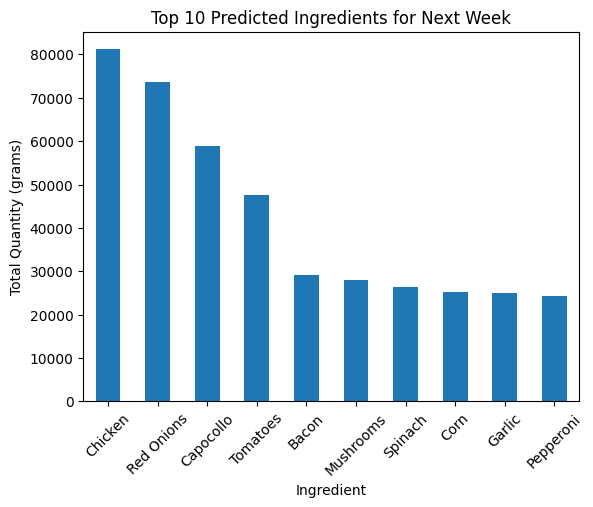

In [81]:
# Visualizing the total quantities of ingredients
plt.figure(figsize=(12, 8))
ingredient_totals_df.nlargest(10, 'Total Quantity (grams)').plot(kind='bar', x='Ingredient', y='Total Quantity (grams)', legend=False)
plt.title('Top 10 Predicted Ingredients for Next Week')
plt.ylabel('Total Quantity (grams)')
plt.xticks(rotation=45)
plt.show()